In [19]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

s = tf.InteractiveSession()

/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/My Drive/DL-HW1/Q1_train.csv')

In [5]:
#Getting the labels
labels = data.iloc[:,0]
data.drop(columns = ['label'],inplace = True)
#standarizing
data = data/255

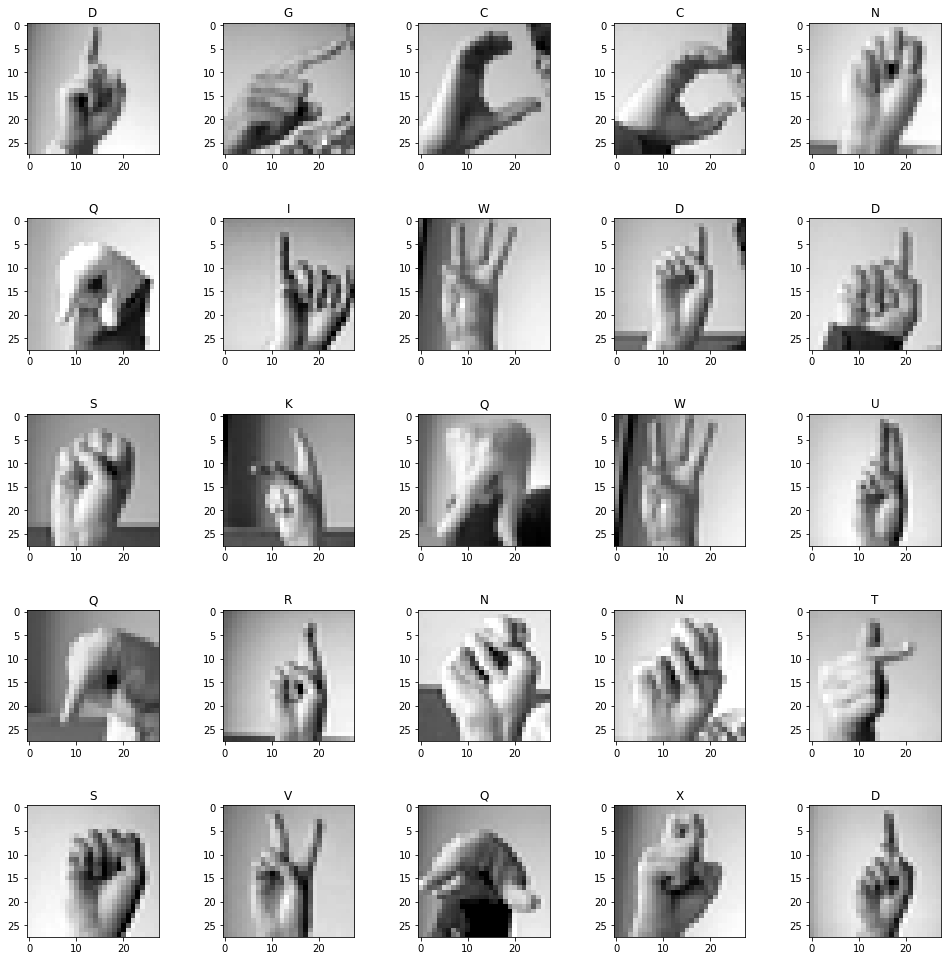

In [20]:
fig , ax = plt.subplots(nrows=5, ncols= 5, figsize = (14, 14))
ax = ax.flatten()
fig.tight_layout(pad=3.0)
for i, a in enumerate(ax):   
    a.imshow(data.values[i][:].reshape(28, 28), cmap = 'gray')
    a.set(title = string.ascii_letters[26+labels[i]])

In [7]:
#splitting the data
X_train, X_validation, y_train, y_validation = train_test_split(data, labels,test_size = 0.2, random_state = 123)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_validation = lb.transform(y_validation)

In [8]:
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
num_layers_2 = 128
starter_learning_rate = 0.0005
starter_learning_rate2 = 0.025

In [9]:
X_in = tf.placeholder('float32',shape =(None,num_features),name="X_in")
y_in = tf.placeholder('float32',shape = (None,num_classes),name='y_in')

In [10]:
# Weights initialized by random normal function with std_dev = sqrt(4/(number of input features+ number of output features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(tf.sqrt(4/float(num_features + num_layers_0 )))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(tf.sqrt(4/float(num_layers_0 + num_layers_1)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_layers_2], stddev=(tf.sqrt(4/float(num_layers_1 + num_layers_2)))))
bias_2 = tf.Variable(tf.random_normal([num_layers_2]))
weights_3 = tf.Variable(tf.random_normal([num_layers_2,num_output], stddev=(1/tf.sqrt(float(num_layers_2)))))
bias_3 = tf.Variable(tf.random_normal([num_output]))

In [11]:
# Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(X_in,weights_0)   +bias_0)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0,weights_1)  +bias_1)
hidden_output_2 = tf.nn.relu(tf.matmul(hidden_output_1,weights_2) +bias_2)
y_pred = tf.sigmoid(tf.matmul(hidden_output_2,weights_3)+ bias_3)

In [12]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred,labels=y_in))
#learning rate of Dynamic type
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.95, staircase=True)
learning_rate2 = tf.train.exponential_decay(starter_learning_rate, 0, 4, 0.95, staircase=True)

In [13]:
# Adam optimzer for finding the right weight
optimizer_adam = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2, weights_3,
                                                                         bias_0,bias_1,bias_2, bias_3])
optimizer_sgd = tf.train.GradientDescentOptimizer(starter_learning_rate2).minimize(loss,var_list=[weights_0,weights_1,weights_2, weights_3,
                                                                         bias_0,bias_1,bias_2, bias_3])

In [14]:
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
X_train, X_validation= X_train.values, X_validation.values

In [26]:
# Training parameters
batch_size = 64
epochs= 20
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 2.68 Train acc: 0.338, Test acc:0.391
Epoch:1, Train loss: 2.58 Train acc: 0.436, Test acc:0.493
Epoch:2, Train loss: 2.55 Train acc: 0.437, Test acc:0.472
Epoch:3, Train loss: 2.49 Train acc: 0.549, Test acc:0.621
Epoch:4, Train loss: 2.47 Train acc: 0.544, Test acc:0.600
Epoch:5, Train loss: 2.45 Train acc: 0.563, Test acc:0.616
Epoch:6, Train loss: 2.47 Train acc: 0.567, Test acc:0.624
Epoch:7, Train loss: 2.42 Train acc: 0.634, Test acc:0.700
Epoch:8, Train loss: 2.40 Train acc: 0.679, Test acc:0.730
Epoch:9, Train loss: 2.39 Train acc: 0.696, Test acc:0.754
Epoch:10, Train loss: 2.38 Train acc: 0.716, Test acc:0.777
Epoch:11, Train loss: 2.39 Train acc: 0.678, Test acc:0.708
Epoch:12, Train loss: 2.36 Train acc: 0.744, Test acc:0.793
Epoch:13, Train loss: 2.35 Train acc: 0.753, Test acc:0.811
Epoch:14, Train loss: 2.35 Train acc: 0.768, Test acc:0.814
Epoch:15, Train loss: 2.35 Train acc: 0.762, Test acc:0.821
Epoch:16, Train loss: 2.34 Train acc: 0.788, Test 

Train Accuracy: 0.80
Test Accuracy:0.83
Train Accuracy: 2.33
Test Accuracy:2.33


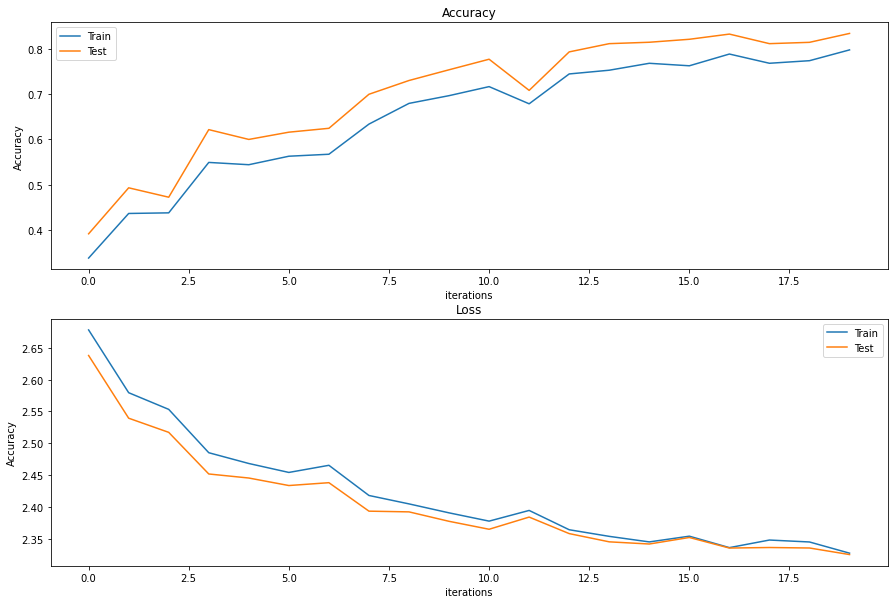

In [27]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Accuracy: {0:.2f}".format(training_loss[-1]))
print("Test Accuracy:{0:.2f}".format(testing_loss[-1]))

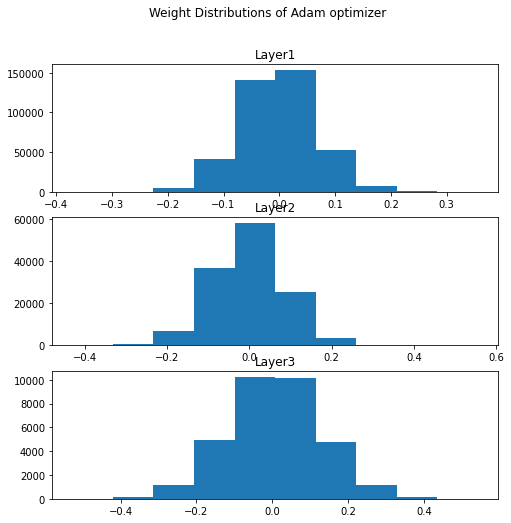

In [28]:
fig, ax = plt.subplots(nrows = 3, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    else : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of Adam optimizer');

In [16]:
# Training parameters
X_train = X_train + (0.35)*np.random.randn(X_train.shape[0],X_train.shape[1])
batch_size = 128
epochs=250
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
       s.run(optimizer_sgd, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    if epoch%10 == 0:
      print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")

Epoch:0, Train loss: 3.13 Train acc: 0.072, Test acc:0.076
Epoch:10, Train loss: 2.69 Train acc: 0.321, Test acc:0.375
Epoch:20, Train loss: 2.60 Train acc: 0.419, Test acc:0.485
Epoch:30, Train loss: 2.55 Train acc: 0.466, Test acc:0.545
Epoch:40, Train loss: 2.52 Train acc: 0.494, Test acc:0.587
Epoch:50, Train loss: 2.50 Train acc: 0.511, Test acc:0.588
Epoch:60, Train loss: 2.47 Train acc: 0.548, Test acc:0.646
Epoch:70, Train loss: 2.45 Train acc: 0.569, Test acc:0.657
Epoch:80, Train loss: 2.44 Train acc: 0.585, Test acc:0.673
Epoch:90, Train loss: 2.43 Train acc: 0.599, Test acc:0.685
Epoch:100, Train loss: 2.42 Train acc: 0.614, Test acc:0.703
Epoch:110, Train loss: 2.41 Train acc: 0.617, Test acc:0.697
Epoch:120, Train loss: 2.40 Train acc: 0.636, Test acc:0.720
Epoch:130, Train loss: 2.39 Train acc: 0.648, Test acc:0.734
Epoch:140, Train loss: 2.38 Train acc: 0.653, Test acc:0.737
Epoch:150, Train loss: 2.38 Train acc: 0.659, Test acc:0.744
Epoch:160, Train loss: 2.37 Train a

Train Accuracy: 0.72
Test Accuracy:0.80
Train Loss: 2.34
Test Loss:2.36


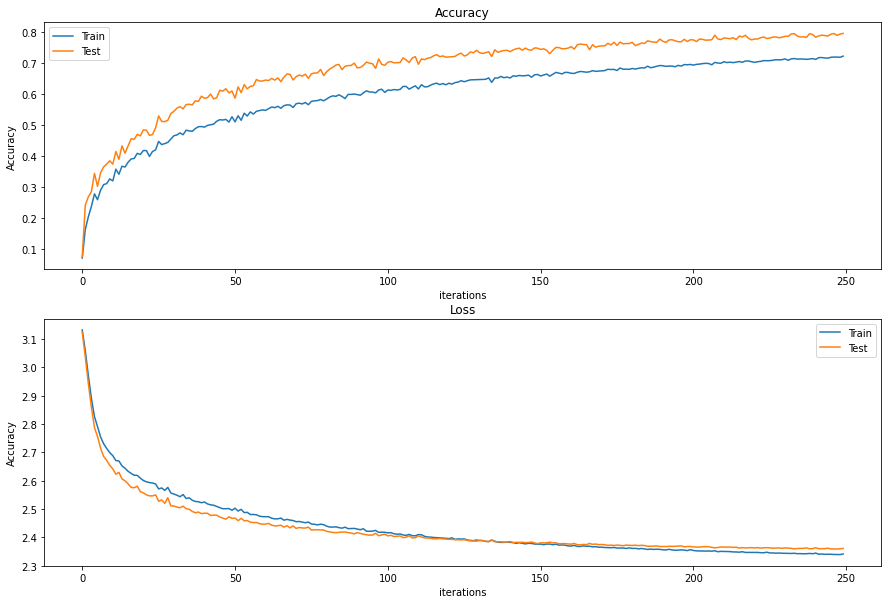

In [18]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

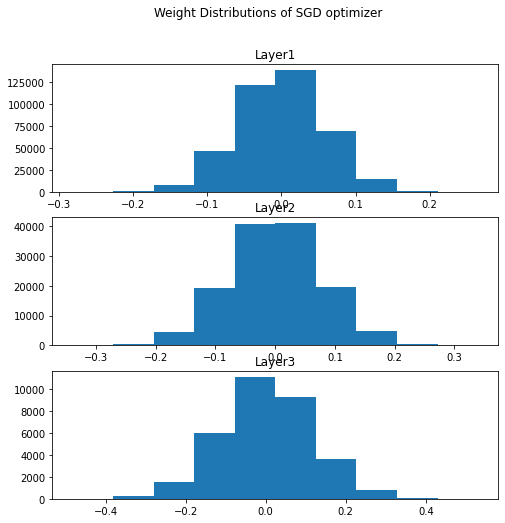

In [17]:
fig, ax = plt.subplots(nrows = 3, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    else : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of SGD optimizer');